### Load documents with IDs

- Loads a JSON file (`documents-with-ids.json`) containing documents with unique IDs used for RAG.

In [1]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/search_evaluation/'

docs_url = url_prefix + 'documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
ground_truth = df_ground_truth.to_dict(orient='records')

In [2]:
# sample of the orginal FAQ

documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [3]:
# lets create a map (dict) id to text
doc_idx = {d['id']: d for d in documents}

# here text is the answers to the questions
sample_data = doc_idx['c02e79ef']['text']
print(f'At id \'c02e79ef\' we have\n{sample_data}')

At id 'c02e79ef' we have
The purpose of this document is to capture frequently asked technical questions
The exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1
Subscribe to course public Google Calendar (it works from Desktop only).
Register before the course starts using this link.
Join the course Telegram channel with announcements.
Don’t forget to register in DataTalks.Club's Slack and join the channel.


> now that we the data we want, it needs to be `indexed`.

### Index Data

#### Indexing:

Is the process of storing data in a structured way that allows for fast and efficient retrieval.

So let's use `elasticsearch` here.


Step 1: Pick a Transformer Model


In [4]:
from sentence_transformers import SentenceTransformer
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

### What did we do in this step?

#### Picked a Transformer Model

- This is a bi-encoder model trained for semantic similarity (e.g., question–answer retrieval)
- It turns input text into a 384-dimensional vector.
- You chose this so that instead of using exact words, you can compare meanings.

### Step 2: Connect to Elasticsearch

In [5]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200')

In [6]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            }
        }
    }
}

# setting the name of the Elasticsearch index
index_name = "course-questions"

# This deletes the existing index named "course-questions" if it already exists.
# for the purpose of index exist error, we can find a better way of dealing with this
es_client.indices.delete(index=index_name, ignore_unavailable=True)

# This creates a new index named "course-questions" using the settings and mappings defined in index_settings.
es_client.indices.create(index=index_name, body=index_settings)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

### Step 3: Define and Create the Index

#### Think of the index like this:

> An index in Elasticsearch is like a database table that's been created with a structure (`settings` + `mappings`) but no data yet.

- At creation, it’s empty, just a “container” with rules.
- You can then send documents into it, one by one or in bulk.
- As long as each document matches the mapping rules (e.g., `question_text_vector` must be a list of 384 floats), it will be accepted.

### Now lets prepare and send out data to our index (database)

- for prgress bar we will use the `tqdm`
    - `tqdm.auto` automatically decides the best way to show the progress bar

In [7]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

- You take the question and text fields,

- Concatenate them,

- Encode the result using your transformer model, producing a vector,

- Store that vector inside the doc under the question_text_vector key.

- You send this updated document to Elasticsearch.

> Now that we have our knowledge DB, it's time to perforem different actions on it



### Retrieval 
- searching in the knowledge db

In [8]:
# field: the vector field to search in (e.g., 'question_text_vector')
# vector: the query vector you’re searching for
# course: filters results only to this course (e.g., "data-engineering")

def elastic_search_knn(field, vector, course):

    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5, # top 5 
        "num_candidates": 10000, # Elasticsearch looks at up to 10,000 docs to find the best 5 (k). This improves quality.
        # filter: only search documents that belong to the
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    # _source: only return these fields in the result (not everything), to keep it clean.
    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    # Runs the search in Elasticsearch using the query we just built.
    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    
    # ['hits']['hits'] is a list of  list of individual matched documents.
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

# prepare your query
def question_text_vector_knn(q):
    
    # get the question text and course from the input q
    question = q['question']
    course = q['course']

    
    # use your transformer model to turn the question into a vector
    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

### knn (k-nearest neighbors)

`knn` - In Elasticsearch, starting from version 8.0+, there's built-in support for k-NN (k-nearest neighbors) search on dense vectors.

```json
"knn": {
    "field": "question_text_vector",
    "query_vector": [...],
    "k": 5,
    "num_candidates": 10000,
    "filter": {
        "term": {"course": "search101"}
    }
}

```
this is Elasticsearch-specific syntax for dense vector search (using their built-in k-NN engine like HNSW).

So:

- `field` tells Elasticsearch which vector field to compare.

- `query_vector` is the encoded input vector.

- `k` is how many similar results you want.

- `num_candidates` affects performance/quality.

- `filter` lets you limit the search (e.g., by course).


### What is `['hits']['hits']`?

When you run a search in Elasticsearch, the response is a nested JSON object. It looks something like this:

```json
{
  "hits": {
    "total": 123,
    "hits": [
      {"_source": {...}},  // 1st result
      {"_source": {...}},  // 2nd result
      ...
    ]
  }
}

```
So:

- `es_results['hits']` → gives you the whole section of search results.

- `es_results['hits']['hits']` → gives you just the list of individual matched documents.

Then inside each hit, the actual document is found under `['_source']`.


### 🧠 Important point

- The `model` is not doing the search.

- `knn` is not doing the embedding.

They’re separate, but used together:

   -  `Model` = turns input → vector.

   -  `k-NN` = finds vectors most similar to it



##### Now that we have our knowledge DB and the way we do search on it (`knn`), let's test it.

In [9]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'section': 'General course-related questions',
  'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'id': '5170565b'},
 {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'section': 'General course-related questions',
  'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'id': '39fda9f0'},
 {'text': '(Hrithik Kumar Advani)',
  'section': '2. Machine Learning for Regression',
  'question': 'Useful Resource for

#### Now we have retrival working let go the next step. using the llm to give smarter answer. 

###

### The RAG Flow

> Take a question → find related answers (knn search) → feed both to GPT (llm) → get a smart, grounded response.

#### Let prepare the `prompt` for our llm model. This will shape the answer we get at the final result.

In [10]:
# query: the user’s question (a string)
# search_results: a list of documents returned from Elasticsearch
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip() # strip to remove a place whitespaces at the start and end of a string

    context = ""
    
    # from the list of documents we get from Elasticsearch (after knn), get the secion question and text fields
    # so we can use them as a context
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    # format the prompt, the .format will help as insert the variables in the {}
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

We buidl the promp function which gives us a nicely formated formated query for the llm. Now lets get do the communication with LLM (chatgpt).

In [11]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-3.5-turbo-1106'):
    
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    print
    
    return response.choices[0].message.content

#### now lets investigate the code.

In [12]:
# example
response = client.chat.completions.create(model='gpt-3.5-turbo-1106', messages=[{"role": "user", "content": "hi"}])

print("\nThe type of reponse:\n")
print(type(response))

print("\nOur repsonse object looks like this:\n")
print(response.model_dump())

print("\nThis goes in the object tree of datastructures get what we need, which is the chat reponse:\n")
print(response.choices[0].message.content)


The type of reponse:

<class 'openai.types.chat.chat_completion.ChatCompletion'>

Our repsonse object looks like this:

{'id': 'chatcmpl-BuWHzIdcpfo0zpXC02fSVnuZTJISi', 'choices': [{'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': 'Hello! How are you today? Is there anything I can help you with?', 'refusal': None, 'role': 'assistant', 'annotations': [], 'audio': None, 'function_call': None, 'tool_calls': None}}], 'created': 1752810187, 'model': 'gpt-3.5-turbo-1106', 'object': 'chat.completion', 'service_tier': 'default', 'system_fingerprint': 'fp_982035f36f', 'usage': {'completion_tokens': 16, 'prompt_tokens': 8, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}}

This goes in the object tree of datastructures get what we need, which is the chat reponse:

Hello! How are you today? Is 

### How we accessed the `<class 'openai.types.chat.chat_completion.ChatCompletion'>` object repsonse 
```
response
├── choices (list)
│   └── [0]|
│       └── message (dict)
│           └── content → 🟩 "Hello! How can I assist you today?"

```

### role field
- `system` and `user`

`"system"`: Tells the assistant how to answer (the behavior or style). (we are telling it in our prompt, but we could also set that using the system role).

`"user"`: Gives the assistant what to answer (the question or input).

- The assistant replies based on both the system’s instructions and the user’s input.

In [13]:
# example
client = OpenAI()

messages = [
    {"role": "system", "content": "You are a friendly assistant who replies with short answers."},
    {"role": "user", "content": "What's the capital of France?"}
]

response = client.chat.completions.create(
    model="gpt-3.5-turbo-1106",
    messages=messages
)
print(response.choices[0].message.content)

Paris.


### now we ahve the `search using knn` and `llm response` functions, the only missing is a function that combines these two and provide a final result.

In [14]:
def rag(query: dict, model="gpt-3.5-turbo-1106") -> str:
    
    # get top k answers
    search_results = question_text_vector_knn(query)
    
    # build prompt, using question and search result
    prompt = build_prompt(query['question'], search_results)
    
    # feed llm with prompt, and choose the model
    answer = llm(prompt, model=model)
    return answer

Now lets check our `rag` function (rag search):

In [15]:
ground_truth[10] 

{'question': 'Can I enroll in the course after it starts?',
 'course': 'data-engineering-zoomcamp',
 'document': '7842b56a'}

In [16]:
rag(ground_truth[10])

'Yes, you can enroll in the course after it starts. You are still eligible to submit homework, but be aware that there will be deadlines for turning in the final projects. After the course finishes, you can also follow the course at your own pace and continue preparing for the next cohort. However, you can only get a certificate if you finish the course with a "live" cohort.'

### Now we have a working RAG system, it's time to evauate using evaluating metrics

#### offline-evaluation 1 :  Cosine Similarity Metric

Rember in the past lessons that we used the dot product of vectors the see the similarity between then, so lets see that here again.

In [17]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.7591169

In [18]:
ground_truth[0]

{'question': 'When does the course begin?',
 'course': 'data-engineering-zoomcamp',
 'document': 'c02e79ef'}

In [19]:

len(ground_truth)

4627

In [20]:
answers = {}

#####  Here let limit it 20 question, so we don't waste time and token

In [21]:
from tqdm import tqdm

answers = {}

for i, rec in enumerate(tqdm(ground_truth[:20])):
    if i in answers:
        continue

    
    answer_llm = rag(rec)  # Generate LLM-based answer
    doc_id = rec['document']  # Get the original document ID from the CSV
    original_doc = doc_idx[doc_id] # Look up the original document by ID
    answer_orig = original_doc['text'] # Get the original answer text

    answers[i] = {
        'id':i,
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


#### Now lets update the ground_truth

In [22]:
# using length 20 
results_gpt4o = [None] * 20

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [23]:
len(ground_truth)
print(results_gpt4o)

[{'id': 0, 'answer_llm': 'The course will begin on the 15th of January, 2024, at 17h00.', 'answer_orig': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.", 'document': 'c02e79ef', 'question': 'When does the course begin?', 'course': 'data-engineering-zoomcamp'}, {'id': 1, 'answer_llm': "You can get the course schedule by subscribing to the course public Google Calendar, registering before the course starts using the provided link, and joining the course Telegram channel with announcements. Additionally, don’t forget to register in DataTalks.Club's Slack and join the channel to

In [24]:
import pandas as pd
df_gpt4o = pd.DataFrame(results_gpt4o)

In [25]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mkdir: data: File exists


In [26]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

In [27]:
print(doc_id)

0bbf41ec


In [28]:
print(ground_truth)

[{'question': 'When does the course begin?', 'course': 'data-engineering-zoomcamp', 'document': 'c02e79ef'}, {'question': 'How can I get the course schedule?', 'course': 'data-engineering-zoomcamp', 'document': 'c02e79ef'}, {'question': 'What is the link for course registration?', 'course': 'data-engineering-zoomcamp', 'document': 'c02e79ef'}, {'question': 'How can I receive course announcements?', 'course': 'data-engineering-zoomcamp', 'document': 'c02e79ef'}, {'question': 'Where do I join the Slack channel?', 'course': 'data-engineering-zoomcamp', 'document': 'c02e79ef'}, {'question': 'Where can I find the prerequisites for this course?', 'course': 'data-engineering-zoomcamp', 'document': '1f6520ca'}, {'question': 'How do I check the prerequisites for this course?', 'course': 'data-engineering-zoomcamp', 'document': '1f6520ca'}, {'question': 'Where are the course prerequisites listed?', 'course': 'data-engineering-zoomcamp', 'document': '1f6520ca'}, {'question': 'What are the require

#### We have the LLM answer and ground tuth data, `answers` contains both and other metadatas. So, lets start evaluating.

## Evaluating GPT 3.5

In [29]:
rag(ground_truth[10], model='gpt-3.5-turbo')

'No, you cannot enroll in the course after it starts. It is recommended to register before the course starts to be able to participate fully and submit homeworks on time.'

#### Helper function to map a function to a sequence with progress bar 
- Uses a thread pool to parallelize the processing,
- showing progress with tqdm.

In [30]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

##### Process a single record 
- Given a record from ground_truth and a model name,
- it calls the RAG function to generate an answer,
- retrieves the original document text,
- and returns a dictionary with relevant information.

In [31]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [32]:
process_record(ground_truth[10])

{'answer_llm': 'Based on the information provided in the FAQ database, you can enroll in the course after it starts and still be eligible to submit homework. However, it is recommended not to leave everything for the last minute as there will be deadlines for turning in the final projects.',
 'answer_orig': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.",
 'document': '7842b56a',
 'question': 'Can I enroll in the course after it starts?',
 'course': 'data-engineering-zoomcamp'}

In [33]:
results_gpt35 = map_progress(pool, ground_truth[:20], process_record)

  0%|          | 0/20 [00:00<?, ?it/s]

In [34]:
# save results including cosine similarity 
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [35]:
!head data/results-gpt35.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_orig,document,question,course
"The course will begin on 15th Jan 2024 at 17h00 with the first ""Office Hours"" live session.","The purpose of this document is to capture frequently asked technical questions
The exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1
Subscribe to course public Google Calendar (it works from Desktop only).
Register before the course starts using this link.
Join the course Telegram channel with announcements.
Don’t forget to register in DataTalks.Club's Slack and join the channel.",c02e79ef,When does the course begin?,data-engineering-zoomcamp
"To get the course schedule, you can check the Google Calendar, register before the course starts using the provided link, and join the course Telegram channel for announcements. The course will start on 15th Jan 2024 at 17h00 with the first ""Office Hours"" live session.","The purpose of this document is to capture frequently as

### Compute similarity using dot product

In [36]:
%pip install seaborn==0.12.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Computing GPT-4o similarities:   0%|          | 0/20 [00:00<?, ?it/s]

GPT-4o cosine similarity summary:
count    20.000000
mean      0.654056
std       0.148185
min       0.357151
25%       0.554978
50%       0.664342
75%       0.791714
max       0.871068
Name: cosine, dtype: float64


Computing GPT-3.5 similarities:   0%|          | 0/20 [00:00<?, ?it/s]

GPT-3.5 cosine similarity summary:
count    20.000000
mean      0.679217
std       0.133360
min       0.471013
25%       0.565509
50%       0.654781
75%       0.800212
max       0.901569
Name: cosine, dtype: float64
Pandas version: 2.3.1
Seaborn version: 0.12.2


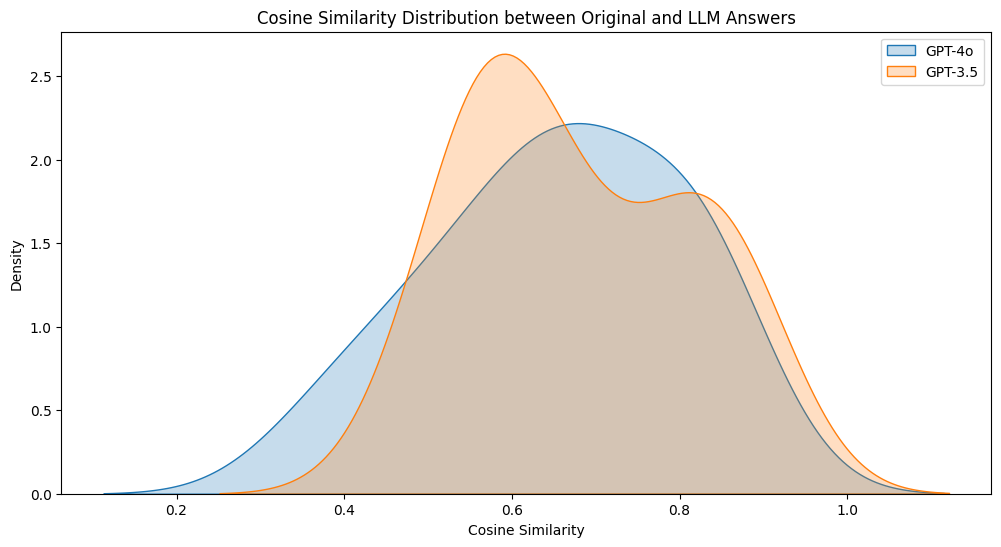

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


# Assuming 'model.encode' is your sentence embedding function (e.g., from sentence-transformers)

def compute_similarity(record):
    """
    Compute cosine similarity between the original answer and the LLM answer.
    """
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    # Dot product as cosine similarity (assuming vectors are normalized)
    return v_llm.dot(v_orig)


# 1. Compute similarity for GPT-4o results
results_gpt4o = df_gpt4o.to_dict(orient='records')

similarity_gpt4o = []
for record in tqdm(results_gpt4o, desc="Computing GPT-4o similarities"):
    sim = compute_similarity(record)
    similarity_gpt4o.append(sim)

df_gpt4o['cosine'] = similarity_gpt4o

print("GPT-4o cosine similarity summary:")
print(df_gpt4o['cosine'].describe())


# 2. Compute similarity for GPT-3.5 results
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_gpt35 = []
for record in tqdm(results_gpt35, desc="Computing GPT-3.5 similarities"):
    sim = compute_similarity(record)
    similarity_gpt35.append(sim)

df_gpt35['cosine'] = similarity_gpt35

print("GPT-3.5 cosine similarity summary:")
print(df_gpt35['cosine'].describe())

print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)

# Replace infinite values with NaN to avoid pandas option error
df_gpt4o['cosine'] = df_gpt4o['cosine'].replace([np.inf, -np.inf], np.nan)
df_gpt35['cosine'] = df_gpt35['cosine'].replace([np.inf, -np.inf], np.nan)

# Drop NaNs before plotting
plt.figure(figsize=(12, 6))
sns.kdeplot(df_gpt4o['cosine'].dropna(), label='GPT-4o', fill=True)
sns.kdeplot(df_gpt35['cosine'].dropna(), label='GPT-3.5', fill=True)

plt.title('Cosine Similarity Distribution between Original and LLM Answers')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()


### What the Graph tells you:

##### 1. The distribution of similarity scores

- It shows how similar pairs of texts/vectors are, across your dataset.

- Cosine similarity ranges from –1 to 1, but for sentence embeddings it’s usually between 0 and 1 (or just above 0), where:

        - 1 = very similar

        - 0 = unrelated


##### 2. Density = frequency (smoothed)

- The y-axis (density) shows how often that similarity value appears.

- It’s a normalized version of frequency — the area under the curve adds up to 1.

In [38]:
print("Seaborn version:", sns.__version__)

Seaborn version: 0.12.2



### Using `LLM-as-a-Judge`

In [39]:
import json

# Purpose: Evaluate the relevance of the generated answer compared to the original answer.
# Evaluation focus: How well does the generated answer match or relate to the original answer provided?

prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

# Purpose: Evaluate the relevance of the generated answer to the given question only.
# Evaluation focus: How well does the generated answer answer the question?
prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

def evaluate_prompt(df, prompt_template, model_name, desc):
    records = df.to_dict(orient='records')
    evaluations = []
    for record in tqdm(records, desc=desc):
        prompt = prompt_template.format(**record)
        eval_str = llm(prompt, model=model_name)
        evaluations.append(eval_str)
    json_evals = []
    for eval_str in evaluations:
        try:
            json_eval = json.loads(eval_str)
        except Exception:
            json_eval = {"Relevance": "ERROR", "Explanation": "Failed to parse JSON from LLM output."}
        json_evals.append(json_eval)
    return pd.DataFrame(json_evals)

# Run evaluations on GPT-4 and GPT-3.5 with both prompts
df_eval_4_prompt1 = evaluate_prompt(df_gpt4o, prompt1_template, 'gpt-4o', "GPT-4 Prompt1 (Compare to original)")
df_eval_4_prompt2 = evaluate_prompt(df_gpt4o, prompt2_template, 'gpt-4o', "GPT-4 Prompt2 (Compare to question)")

df_eval_35_prompt1 = evaluate_prompt(df_gpt35, prompt1_template, 'gpt-3.5-turbo', "GPT-3.5 Prompt1 (Compare to original)")
df_eval_35_prompt2 = evaluate_prompt(df_gpt35, prompt2_template, 'gpt-3.5-turbo', "GPT-3.5 Prompt2 (Compare to question)")

# Show summaries
print("GPT-4 Prompt1 Relevance Counts:")
print(df_eval_4_prompt1['Relevance'].value_counts(dropna=False))
print("\nGPT-4 Prompt2 Relevance Counts:")
print(df_eval_4_prompt2['Relevance'].value_counts(dropna=False))

print("\nGPT-3.5 Prompt1 Relevance Counts:")
print(df_eval_35_prompt1['Relevance'].value_counts(dropna=False))
print("\nGPT-3.5 Prompt2 Relevance Counts:")
print(df_eval_35_prompt2['Relevance'].value_counts(dropna=False))

# Save results
df_eval_4_prompt1.to_csv('eval_gpt4_prompt1.csv', index=False)
df_eval_4_prompt2.to_csv('eval_gpt4_prompt2.csv', index=False)
df_eval_35_prompt1.to_csv('eval_gpt35_prompt1.csv', index=False)
df_eval_35_prompt2.to_csv('eval_gpt35_prompt2.csv', index=False)


GPT-4 Prompt1 (Compare to original):   0%|          | 0/20 [00:00<?, ?it/s]

GPT-4 Prompt2 (Compare to question):   0%|          | 0/20 [00:00<?, ?it/s]

GPT-3.5 Prompt1 (Compare to original):   0%|          | 0/20 [00:00<?, ?it/s]

GPT-3.5 Prompt2 (Compare to question):   0%|          | 0/20 [00:00<?, ?it/s]

GPT-4 Prompt1 Relevance Counts:
Relevance
PARTLY_RELEVANT    10
RELEVANT            9
NON_RELEVANT        1
Name: count, dtype: int64

GPT-4 Prompt2 Relevance Counts:
Relevance
PARTLY_RELEVANT    11
RELEVANT            6
NON_RELEVANT        3
Name: count, dtype: int64

GPT-3.5 Prompt1 Relevance Counts:
Relevance
RELEVANT           11
PARTLY_RELEVANT     9
Name: count, dtype: int64

GPT-3.5 Prompt2 Relevance Counts:
Relevance
PARTLY_RELEVANT    11
RELEVANT            7
NON_RELEVANT        2
Name: count, dtype: int64


# Summary

### LLM as a Judge

- Ask a big model like GPT-4:

    "Is this answer correct?"

It looks at:

- The question

- The answer your system gave

- The correct (ground truth) answer

It replies:
 - Correct, Wrong, or something in between.

- Good for: Checking if the final answer makes sense
- Bad side: Slower and costs more

### Cosine Similarity

- Turn text into numbers (embeddings)

- Measure how close the retrieved text is to the correct one

- Good for: Checking if your system found the right info
- Bad side: Doesn’t check if the final answer is right
 
 
##### Example:

If the question is “What is the capital of France?”

- `Cosine similarity` checks if your system found a document that mentions Paris

- `LLM as a judge` checks if your answer is actually “Paris” and makes sense

# Done!